In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install keras==2.4.3
# !pip install tensorflow==2.4.1

In [3]:
!pip install keras-multi-head
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-multi-head: filename=keras_multi_head-0.29.0-py3-none-any.whl size=14993 sha256=c0b14c2de4d1cb6db33c80ae983bdcc18cc6960a4fd4fecf7ce1b6edba0f6001
  Stored in directory: /root/.cache/pip/wheels/86/aa/3c/9d15d24005179dae08ff291ce99c754b296347817d076fd9fb
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=bb93f86231d9248859183b920a888337cb5ad33850f315cfba2001eb2a9d40ba
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-multi-head keras-self-attention
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import keras
from keras_multi_head import MultiHead
from keras_self_attention import SeqSelfAttention

import numpy as np
import os
import sys

import wave
import copy
import math

import keras

from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation
from keras.layers import GRU, LSTM, Input, Flatten, Concatenate, Embedding, Convolution1D, Dropout, Bidirectional, Conv2D, MaxPooling2D, Conv1D
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import label_binarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelBinarizer




import tensorflow as tf
#from model import AttentionResNet
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [7]:
%cd /content/drive/MyDrive/FINAL THESIS PROJECT/codes

/content/drive/.shortcut-targets-by-id/1-TsISowGVH-c2pg1SMS88BRnBWd9B3c0/FINAL_THESIS_PROJECT/codes


In [8]:
from features import *
from helper import *

In [9]:
code_path = "/content/drive/MyDrive/data"
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])
data_path = code_path + "/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

In [10]:
import pickle
with open(data_path + '/'+'data_collected.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [ ]:
# mocap_hand = []

# for ses_mod in data2:
#     x_hand = ses_mod['mocap_hand']
#     if(x_hand.shape != (200,18)):
#         x_hand = np.zeros((200,18))  
#     x_hand[np.isnan(x_hand)]=0
#     mocap_hand.append( x_hand )
    
# mocap_hand = np.array(mocap_hand)
# # mocap_hand = mocap_hand.reshape(-1,200,18,1)
# mocap_hand.shape

(4936, 200, 18)

In [11]:
mocap_hand = []

for ses_mod in data2:
    x_hand = ses_mod['mocap_hand']
    if(x_hand.shape != (200,18)):
        x_hand = np.zeros((200,18))  
    x_hand[np.isnan(x_hand)]=0
    mocap_hand.append( x_hand )
    
mocap_hand = np.array(mocap_hand)
mocap_hand = mocap_hand.reshape(-1,200,18,1)
mocap_hand.shape


(4936, 200, 18, 1)

In [12]:
Y=[]
# for ses_mod in data2:
    # Y.append(ses_mod['emotion'])
    
# Y = label_binarize(Y,emotions_used)

# Y.shape

for ses_mod in data2:
  if ses_mod['emotion'] == 'neu':
    Y.append(0)
  elif ses_mod['emotion'] == 'ang':
    Y.append(1)
  elif ses_mod['emotion'] == 'exc':
    Y.append(2)
  elif ses_mod['emotion'] == 'sad':
    Y.append(3)

Y = np.array(Y)
print(type(Y))
Y[0],Y[1], Y[2]

<class 'numpy.ndarray'>


(0, 0, 0)

In [ ]:
# for ses_mod in data2:
#   if ses_mod['emotion'] == 'neu':
#     Y.append(0)
#   elif ses_mod['emotion'] == 'ang':
#     Y.append(1)
#   elif ses_mod['emotion'] == 'exc':
#     Y.append(2)
#   elif ses_mod['emotion'] == 'sad':
#     Y.append(3)

# Y = np.array(Y)
# print(type(Y))
# Y[0],Y[1], Y[2]

In [13]:
counter = 0
for ses_mod in data2:
    if (ses_mod['id'][:5]=="Ses05"):
        break
    counter+=1
counter

3838

In [14]:
xtrain_mocap_hand = mocap_hand[:3838]
xtest_mocap_hand = mocap_hand[3838:]
ytrain_mocap_hand = Y[:3838]
ytest_mocap_hand = Y[3838:]

print(xtrain_mocap_hand.shape)
print(xtest_mocap_hand.shape)
print(type(xtrain_mocap_hand))
print(type(xtest_mocap_hand))

print(ytrain_mocap_hand.shape)
print(ytest_mocap_hand.shape)
print(type(ytrain_mocap_hand))
print(type(ytest_mocap_hand))

(3838, 200, 18, 1)
(1098, 200, 18, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3838,)
(1098,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#**Model_Head 1A**

In [15]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention

def create_model_1():
    img_inputs = keras.Input(shape=(200, 18, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)
    flatten = keras.layers.Flatten()(conv_5)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [16]:
model = create_model_1()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 18, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 18, 256)      2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 9, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 9, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 4, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 4, 128)        147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 4, 128)        147584

In [17]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [18]:
hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=150, epochs=300, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/300
26/26 [==============================] - 18s 162ms/step - loss: 1.9838 - acc: 0.2815 - val_loss: 1.8006 - val_acc: 0.2468
Epoch 2/300
26/26 [==============================] - 3s 106ms/step - loss: 1.3489 - acc: 0.4078 - val_loss: 1.7418 - val_acc: 0.2413
Epoch 3/300
26/26 [==============================] - 3s 103ms/step - loss: 1.2392 - acc: 0.4507 - val_loss: 1.6585 - val_acc: 0.2514
Epoch 4/300
26/26 [==============================] - 3s 101ms/step - loss: 1.1829 - acc: 0.4789 - val_loss: 1.6099 - val_acc: 0.2987
Epoch 5/300
26/26 [==============================] - 3s 102ms/step - loss: 1.1484 - acc: 0.4940 - val_loss: 1.7254 - val_acc: 0.2441
Epoch 6/300
26/26 [==============================] - 3s 102ms/step - loss: 1.1092 - acc: 0.5150 - val_loss: 1.6647 - val_acc: 0.3087
Epoch 7/300
26/26 [==============================] - 3s 102ms/step - loss: 1.0594 - acc: 0.5419 - val_loss: 1.6631 - val_acc: 0.3188
Epoch 8/300
26/26 [==============================] - 3s 102ms/step -

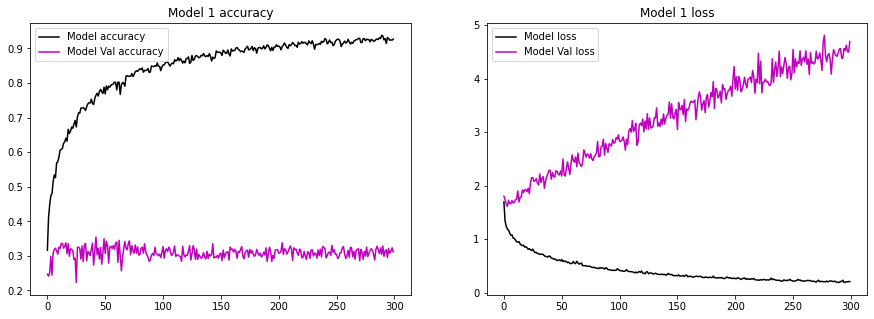

In [19]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [20]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [21]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.17361 dan Training Accuracy 93.72%
Validation Loss 4.69764 dan Validation Accuracy 31.15%


# **Model_Head 1B**

In [22]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional

def create_model_2():
    img_inputs = keras.Input(shape=(200, 18, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)

    x = Reshape((-1, 128))(conv_5)
    
    #LSTM
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(128, return_sequences=False)(x)


    flatten = keras.layers.Flatten()(x)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [23]:
model = create_model_2()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 18, 1)]      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 200, 18, 256)      2560      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 9, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 9, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 4, 256)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 4, 128)        295040    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 4, 128)        1475

In [24]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [25]:
hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=150, epochs=300, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/300
26/26 [==============================] - 12s 285ms/step - loss: 1.3744 - acc: 0.2986 - val_loss: 1.3906 - val_acc: 0.3352
Epoch 2/300
26/26 [==============================] - 4s 168ms/step - loss: 1.3460 - acc: 0.3426 - val_loss: 1.3989 - val_acc: 0.3370
Epoch 3/300
26/26 [==============================] - 4s 168ms/step - loss: 1.3202 - acc: 0.3866 - val_loss: 1.4144 - val_acc: 0.2887
Epoch 4/300
26/26 [==============================] - 4s 168ms/step - loss: 1.3092 - acc: 0.4037 - val_loss: 1.4331 - val_acc: 0.2860
Epoch 5/300
26/26 [==============================] - 4s 168ms/step - loss: 1.2942 - acc: 0.4190 - val_loss: 1.4369 - val_acc: 0.2878
Epoch 6/300
26/26 [==============================] - 4s 168ms/step - loss: 1.2742 - acc: 0.4312 - val_loss: 1.4639 - val_acc: 0.2796
Epoch 7/300
26/26 [==============================] - 4s 168ms/step - loss: 1.2718 - acc: 0.4321 - val_loss: 1.4747 - val_acc: 0.2659
Epoch 8/300
26/26 [==============================] - 4s 168ms/step -

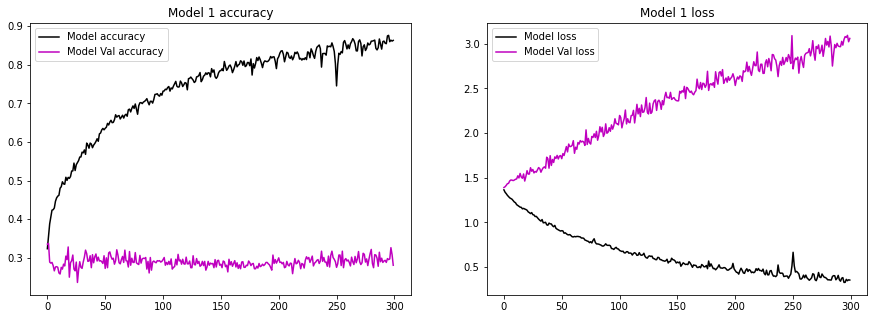

In [26]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [27]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [28]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.33581 dan Training Accuracy 87.13%
Validation Loss 3.05814 dan Validation Accuracy 28.05%


# **Model_Head 1C**

In [29]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional

def create_model_3():
    img_inputs = keras.Input(shape=(200, 18, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_2)
    conv_4 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_3)
    conv_5 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(conv_4)

    x = Reshape((-1, 128))(conv_5)
    
    #LSTM
    x = LSTM(128, return_sequences=True)(x)
    x = SeqSelfAttention(attention_activation ='tanh')(x)
    x = LSTM(128, return_sequences=False)(x)


    flatten = keras.layers.Flatten()(x)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [30]:
model = create_model_3()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 18, 1)]      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 200, 18, 256)      2560      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 9, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 9, 256)       590080    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 4, 256)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 4, 128)        295040    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 4, 128)        1475

In [31]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [32]:
hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=150, epochs=300, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/300
26/26 [==============================] - 9s 260ms/step - loss: 1.3691 - acc: 0.2991 - val_loss: 1.3825 - val_acc: 0.3497
Epoch 2/300
26/26 [==============================] - 6s 226ms/step - loss: 1.3432 - acc: 0.3406 - val_loss: 1.3908 - val_acc: 0.3497
Epoch 3/300
26/26 [==============================] - 6s 224ms/step - loss: 1.3248 - acc: 0.3707 - val_loss: 1.3943 - val_acc: 0.3497
Epoch 4/300
26/26 [==============================] - 6s 225ms/step - loss: 1.3150 - acc: 0.3760 - val_loss: 1.4006 - val_acc: 0.3497
Epoch 5/300
26/26 [==============================] - 6s 224ms/step - loss: 1.2824 - acc: 0.4138 - val_loss: 1.4089 - val_acc: 0.3543
Epoch 6/300
26/26 [==============================] - 6s 224ms/step - loss: 1.2707 - acc: 0.4285 - val_loss: 1.4312 - val_acc: 0.3534
Epoch 7/300
26/26 [==============================] - 6s 225ms/step - loss: 1.2531 - acc: 0.4264 - val_loss: 1.4296 - val_acc: 0.3224
Epoch 8/300
26/26 [==============================] - 6s 225ms/step - 

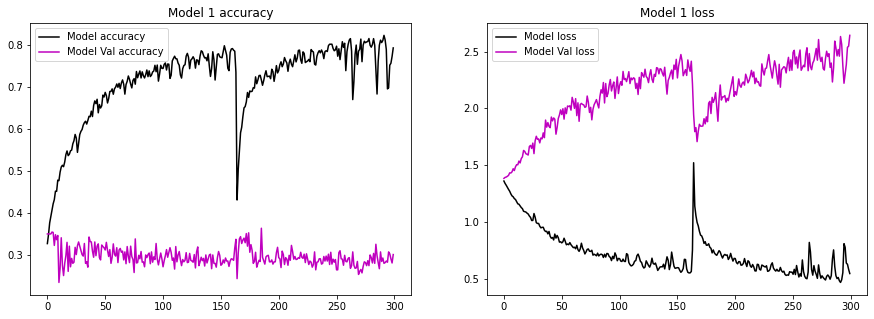

In [33]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [34]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [35]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.52689 dan Training Accuracy 80.46%
Validation Loss 2.64222 dan Validation Accuracy 30.05%


#**MOCAP HAND 1**

In [ ]:
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention

def create_model():
    img_inputs = keras.Input(shape=(200, 18, 1))
    conv_1 = keras.layers.Conv2D(256, (3, 3), padding="same", activation='relu')(img_inputs)
    maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
    conv_2 = keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu')(maxpool_1)
    maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_2)
    conv_3 = keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu')(maxpool_2)
    flatten = keras.layers.Flatten()(conv_3)
    dense_1 = keras.layers.Dense(128, activation='relu')(flatten)
    output = keras.layers.Dense(4, activation='softmax')(dense_1)

    model = keras.Model(inputs=img_inputs, outputs=output)

    return model

# model.summary()

In [ ]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 200, 18, 1)]      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 200, 18, 256)      2560      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 100, 9, 256)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 100, 9, 128)       295040    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 4, 128)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 4, 64)         73792     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0     

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [ ]:
# from tensorflow.keras import layers

# def hand1():
#   model = Sequential()
#   model.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu', input_shape=(200, 18, 1)))
#   attention_layer = attention()(RNN_layer)
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
#   model.add(layers.MaxPooling2D((2, 2)))
#   model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
#   model.add(layers.Flatten())
#   model.add(layers.Dense(128, activation='relu'))
#   model.add(layers.Dense(4))
#   model.add(Activation('softmax'))

#   model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
#   # model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

#   return model

In [ ]:
# model = hand1()
# model.summary()

In [ ]:
# def gru_model_hand1():
#     model = Sequential()
#     model.add(GRU(512, activation='relu', return_sequences=True, input_shape=(200, 18)))
#     model.add(GRU(256, activation='relu', return_sequences=True))
#     model.add(GRU(128, activation='relu', return_sequences=False))

#     model.add(Dense(256))
#     model.add(Activation('relu'))
#     model.add(Dense(4))
#     model.add(Activation('softmax'))

#     model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

#     return model

In [ ]:
# model = gru_model_hand1()
# model.summary()

hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=100, epochs=300, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/300
39/39 [==============================] - 17s 103ms/step - loss: 4.8520 - acc: 0.2864 - val_loss: 2.9131 - val_acc: 0.2377
Epoch 2/300
39/39 [==============================] - 2s 64ms/step - loss: 1.9505 - acc: 0.3508 - val_loss: 2.6318 - val_acc: 0.2395
Epoch 3/300
39/39 [==============================] - 3s 64ms/step - loss: 1.6440 - acc: 0.4054 - val_loss: 2.5689 - val_acc: 0.2441
Epoch 4/300
39/39 [==============================] - 3s 65ms/step - loss: 1.5036 - acc: 0.4372 - val_loss: 2.3527 - val_acc: 0.2477
Epoch 5/300
39/39 [==============================] - 2s 64ms/step - loss: 1.4505 - acc: 0.4377 - val_loss: 2.1647 - val_acc: 0.2905
Epoch 6/300
39/39 [==============================] - 3s 68ms/step - loss: 1.3246 - acc: 0.4770 - val_loss: 2.2377 - val_acc: 0.2468
Epoch 7/300
39/39 [==============================] - 3s 70ms/step - loss: 1.3173 - acc: 0.4806 - val_loss: 2.0814 - val_acc: 0.3206
Epoch 8/300
39/39 [==============================] - 3s 67ms/step - loss: 

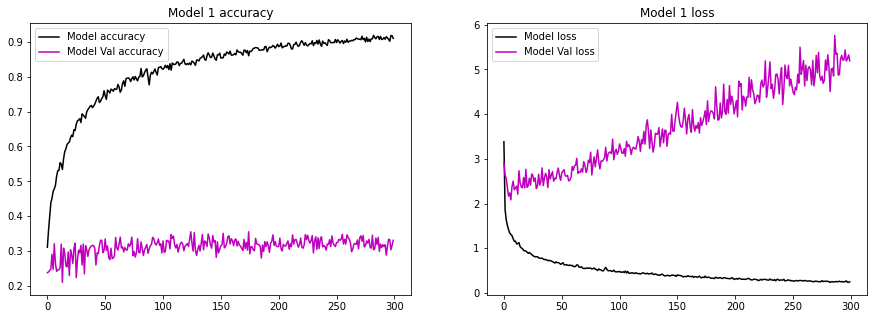

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.22128 dan Training Accuracy 92.29%
Validation Loss 5.19353 dan Validation Accuracy 33.06%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_hand)
pred = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_hand, pred, target_names=emotions_used))

In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_hand, labels, target_names = emotions_used))

model 1


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_hand)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_hand,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL_HAND 2**

In [ ]:
def gru_model_hand2():
  model = Sequential()
  model.add(GRU(512, return_sequences=True, input_shape=(200, 18)))
  model.add(SeqSelfAttention(attention_activation='relu'))
  model.add(GRU(256, activation='relu', return_sequences=True))
  model.add(SeqSelfAttention(attention_activation='relu'))
  model.add(GRU(128, activation='relu', return_sequences=False))
 

  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(4))
  model.add(Activation('softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

  return model

In [ ]:
model = gru_model_hand2()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 200, 512)          817152    
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 512)         32833     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 256)         591360    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
activation (Activation)      (None, 256)               0

In [ ]:
hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=150, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/50
26/26 [==============================] - 47s 1s/step - loss: 1.3005 - accuracy: 0.3982 - val_loss: 1.6154 - val_accuracy: 0.2987
Epoch 2/50
26/26 [==============================] - 24s 913ms/step - loss: 1.1089 - accuracy: 0.5053 - val_loss: 1.6745 - val_accuracy: 0.3370
Epoch 3/50
26/26 [==============================] - 28s 1s/step - loss: 1.0213 - accuracy: 0.5514 - val_loss: 1.9295 - val_accuracy: 0.2914
Epoch 4/50
26/26 [==============================] - 24s 914ms/step - loss: 0.9701 - accuracy: 0.5866 - val_loss: 1.9737 - val_accuracy: 0.2914
Epoch 5/50
26/26 [==============================] - 25s 960ms/step - loss: 0.9129 - accuracy: 0.6271 - val_loss: 2.2430 - val_accuracy: 0.2714
Epoch 6/50
26/26 [==============================] - 24s 928ms/step - loss: 0.9320 - accuracy: 0.6235 - val_loss: 2.4516 - val_accuracy: 0.2596
Epoch 7/50
26/26 [==============================] - 24s 918ms/step - loss: 0.8322 - accuracy: 0.6479 - val_loss: 1.8428 - val_accuracy: 0.2796
Epoch

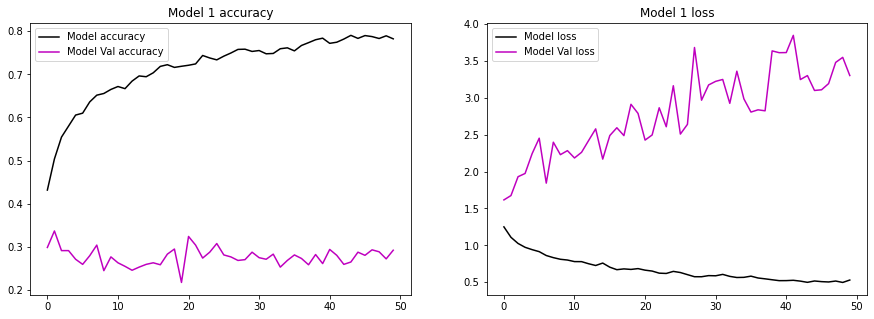

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.97464 dan Training Accuracy 58.60%
Validation Loss 2.10432 dan Validation Accuracy 26.05%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.74      0.47      0.57       933
         exc       0.95      0.33      0.49       742
         neu       0.74      0.46      0.57      1324
         sad       0.49      0.76      0.60       839

   micro avg       0.65      0.50      0.56      3838
   macro avg       0.73      0.50      0.55      3838
weighted avg       0.72      0.50      0.56      3838
 samples avg       0.50      0.50      0.50      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.22      0.44      0.29       170
         exc       0.07      0.01      0.02       299
         neu       0.34      0.43      0.38       384
         sad       0.00      0.00      0.00       245

   micro avg       0.28      0.22      0.25      1098
   macro avg       0.16      0.22      0.17      1098
weighted avg       0.17      0.22      0.18      1098
 samples avg       0.22      0.22      0.22      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


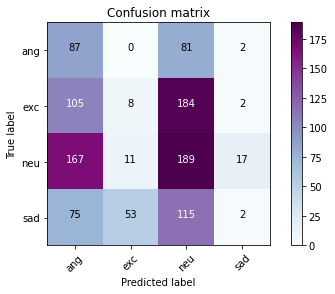

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_hand)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_hand,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL_HAND 3**

In [ ]:
def gru_model_hand3():
    model = Sequential()
    
    model.add(Bidirectional(GRU(512, activation="relu", return_sequences=True), input_shape=(200, 18)))
    model.add(Bidirectional(GRU(256, activation='relu', return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation='relu', return_sequences=False)))
  
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    #print(model.summary())

    return model

In [ ]:
model = gru_model_hand3()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200, 1024)         1634304   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 512)          1969152   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               493056    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [ ]:
hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/50
39/39 [==============================] - 96s 2s/step - loss: 4.1628 - accuracy: 0.3092 - val_loss: 1.5037 - val_accuracy: 0.2960
Epoch 2/50
39/39 [==============================] - 87s 2s/step - loss: 1.2614 - accuracy: 0.4412 - val_loss: 1.4823 - val_accuracy: 0.2969
Epoch 3/50
39/39 [==============================] - 86s 2s/step - loss: 1.2169 - accuracy: 0.4450 - val_loss: 1.7654 - val_accuracy: 0.3142
Epoch 4/50
39/39 [==============================] - 83s 2s/step - loss: 1.1523 - accuracy: 0.4823 - val_loss: 1.7750 - val_accuracy: 0.2240
Epoch 5/50
39/39 [==============================] - 83s 2s/step - loss: 1.0855 - accuracy: 0.5300 - val_loss: 1.7702 - val_accuracy: 0.2623
Epoch 6/50
39/39 [==============================] - 81s 2s/step - loss: 1.0551 - accuracy: 0.5376 - val_loss: 1.7815 - val_accuracy: 0.2650
Epoch 7/50
39/39 [==============================] - 81s 2s/step - loss: 1.0193 - accuracy: 0.5586 - val_loss: 1.8750 - val_accuracy: 0.3042
Epoch 8/50
39/39 [==

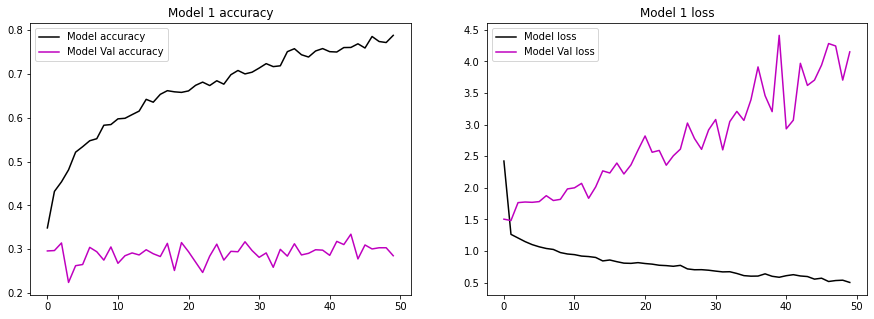

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.61117 dan Training Accuracy 74.05%
Validation Loss 2.47472 dan Validation Accuracy 29.51%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.76      0.69      0.73       933
         exc       0.85      0.61      0.71       742
         neu       0.80      0.64      0.71      1324
         sad       0.80      0.74      0.77       839

   micro avg       0.80      0.67      0.73      3838
   macro avg       0.81      0.67      0.73      3838
weighted avg       0.80      0.67      0.73      3838
 samples avg       0.67      0.67      0.67      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.24      0.22      0.23       170
         exc       0.10      0.04      0.06       299
         neu       0.36      0.56      0.43       384
         sad       0.09      0.01      0.01       245

   micro avg       0.30      0.24      0.27      1098
   macro avg       0.20      0.21      0.19      1098
weighted avg       0.21      0.24      0.21      1098
 samples avg       0.24      0.24      0.24      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


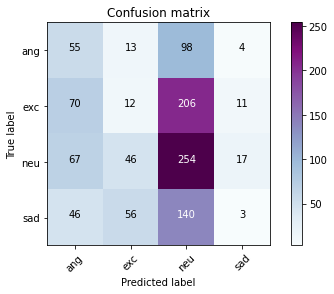

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_hand)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_hand,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

#**MODEL_HAND 4**

In [ ]:
def gru_model_hand4():
    model = Sequential()
    
    model.add(Bidirectional(GRU(128, activation="relu", return_sequences=True), input_shape=(200, 18)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(128, activation='relu', return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation="relu"))
    model.add(Bidirectional(GRU(128, activation='relu', return_sequences=False)))
   
    model.add(Dropout(0.1))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


    #print(model.summary())

    return model

In [ ]:
model = gru_model_hand4()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 200, 256)          113664    
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 256)         296448    
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [ ]:
hist = model.fit(xtrain_mocap_hand, ytrain_mocap_hand, 
                 batch_size=100, epochs=50, verbose=1, shuffle = True, 
                 validation_data=(xtest_mocap_hand, ytest_mocap_hand))

Epoch 1/50
39/39 [==============================] - 93s 2s/step - loss: 2.7683 - accuracy: 0.3581 - val_loss: 1.8826 - val_accuracy: 0.2240
Epoch 2/50
39/39 [==============================] - 82s 2s/step - loss: 1.2827 - accuracy: 0.4598 - val_loss: 1.9136 - val_accuracy: 0.2914
Epoch 3/50
39/39 [==============================] - 84s 2s/step - loss: 1.1556 - accuracy: 0.5100 - val_loss: 2.1697 - val_accuracy: 0.2996
Epoch 4/50
39/39 [==============================] - 86s 2s/step - loss: 1.0731 - accuracy: 0.5259 - val_loss: 1.9512 - val_accuracy: 0.2842
Epoch 5/50
39/39 [==============================] - 85s 2s/step - loss: 1.0139 - accuracy: 0.5769 - val_loss: 2.4098 - val_accuracy: 0.2423
Epoch 6/50
39/39 [==============================] - 86s 2s/step - loss: 1.0022 - accuracy: 0.5709 - val_loss: 2.0683 - val_accuracy: 0.2814
Epoch 7/50
39/39 [==============================] - 85s 2s/step - loss: 0.9900 - accuracy: 0.5773 - val_loss: 2.1831 - val_accuracy: 0.2441
Epoch 8/50
39/39 [==

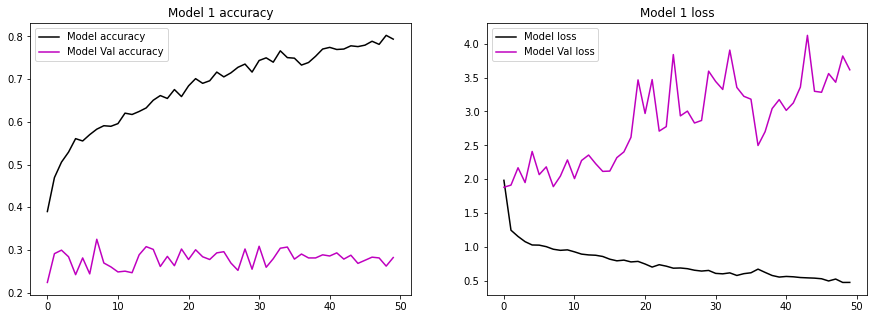

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 1 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 1 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
loss, acc = model.evaluate(xtrain_mocap_hand, ytrain_mocap_hand,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

loss, acc = model.evaluate(xtest_mocap_hand, ytest_mocap_hand,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 1.36106 dan Training Accuracy 34.50%
Validation Loss 1.37772 dan Validation Accuracy 34.97%


In [ ]:
from sklearn.metrics import classification_report
# CR untuk Training Data
print("model 1")
pred = model.predict(xtrain_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytrain_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       933
         exc       0.00      0.00      0.00       742
         neu       0.00      0.00      0.00      1324
         sad       0.00      0.00      0.00       839

   micro avg       0.00      0.00      0.00      3838
   macro avg       0.00      0.00      0.00      3838
weighted avg       0.00      0.00      0.00      3838
 samples avg       0.00      0.00      0.00      3838



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# CR untuk Validation Data
print("model 1")
pred = model.predict(xtest_mocap_hand)
labels = (pred > 0.5).astype(np.int)

print(classification_report(ytest_mocap_hand, labels, target_names = emotions_used))

model 1
              precision    recall  f1-score   support

         ang       0.00      0.00      0.00       170
         exc       0.00      0.00      0.00       299
         neu       0.00      0.00      0.00       384
         sad       0.00      0.00      0.00       245

   micro avg       0.00      0.00      0.00      1098
   macro avg       0.00      0.00      0.00      1098
weighted avg       0.00      0.00      0.00      1098
 samples avg       0.00      0.00      0.00      1098



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


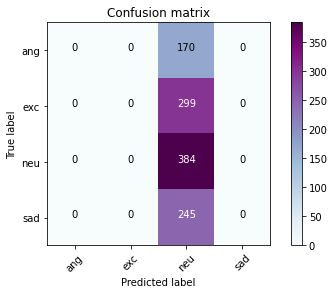

In [ ]:
import itertools
Y_pred = model.predict(xtest_mocap_hand)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(ytest_mocap_hand,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = emotions_used) 

In [ ]:
mocap_rot = []

for ses_mod in data2:
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))  
    x_rot[np.isnan(x_rot)]=0
    mocap_rot.append( x_rot )
    
mocap_rot = np.array(mocap_rot)
mocap_rot.shape

In [ ]:
def lstm_model(optimizer='Adadelta'):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(200, 165)))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = lstm_model()
model.summary()

hist = model.fit(mocap_rot, Y, 
                 batch_size=100, nb_epoch=3, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:

hist = model.fit(mocap_rot, Y, 
                 batch_size=100, nb_epoch=3, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:
def simple_conv(optimizer='Adam'):
    model = Sequential()
    model.add(Conv2D(32, 3, strides=(2, 2), border_mode='same', input_shape=(200, 165, 1)))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = simple_conv()
model.summary()

mocap_rot_re = mocap_rot.reshape(-1,200,165,1)

hist = model.fit(mocap_rot_re, Y, 
                 batch_size=100, nb_epoch=2, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:
def simple_conv2(optimizer='SGD'):
    model = Sequential()
    model.add(Conv2D(32, 3, strides=(2, 2), border_mode='same', input_shape=(200, 165, 1)))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = simple_conv2()
model.summary()

mocap_rot_re = mocap_rot.reshape(-1,200,165,1)

hist = model.fit(mocap_rot_re, Y, 
                 batch_size=100, nb_epoch=1, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:
x_train_mocap = []
counter = 0
for ses_mod in data2:
    x_head = ses_mod['mocap_head']
    if(x_head.shape != (200,18)):
        x_head = np.zeros((200,18))   
    x_head[np.isnan(x_head)]=0
    x_hand = ses_mod['mocap_hand']
    if(x_hand.shape != (200,6)):
        x_hand = np.zeros((200,6))   
    x_hand[np.isnan(x_hand)]=0
    x_rot = ses_mod['mocap_rot']
    if(x_rot.shape != (200,165)):
        x_rot = np.zeros((200,165))   
    x_rot[np.isnan(x_rot)]=0
    x_mocap = np.concatenate((x_head, x_hand), axis=1)
    x_mocap = np.concatenate((x_mocap, x_rot), axis=1)
    x_train_mocap.append( x_mocap )
    
x_train_mocap = np.array(x_train_mocap)
x_train_mocap = x_train_mocap.reshape(-1,200,189,1)
x_train_mocap.shape

In [ ]:
def simple_conv3(optimizer='SGD'):
    model = Sequential()
    model.add(Conv2D(32, 3, strides=(2, 2), border_mode='same', input_shape=(200, 189, 1)))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(64, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3, strides=(2, 2), border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = simple_conv3()
model.summary()


hist = model.fit(x_train_mocap, Y, 
                 batch_size=100, nb_epoch=1, verbose=1, shuffle = True, 
                 validation_split=0.2)

In [ ]:
model = AttentionResNet()